In [1]:
import sys
sys.path.append('../')
import libs.db
import libs.prep_df
import pandas as pd
import sqlite3

In [2]:
tickers = libs.db.get_tickers("sp10.csv")
num_ticks = 60

In [3]:
sql_file = "sp10_historical.db"
conn = libs.db.create_connection(sql_file)
hist_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
hist_df = libs.prep_df.normalize_df(hist_df)

In [4]:
hist_shifted_df = pd.DataFrame()
for ticker in tickers:
    hist_shifted_df[ticker] = hist_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        hist_shifted_df[name] = hist_df[ticker].shift(i)
hist_shifted_df = hist_shifted_df.copy()
hist_shifted_df.shape

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(17080, 600)

In [5]:
hist_pct_returns_df_list = []
for ticker in tickers:
    name = f"{ticker}_Buy"
    returns_df = pd.DataFrame()
    returns_df[name] = hist_df[ticker].pct_change(periods=16).shift(-16).apply(lambda x : 1 if x >= 0.0075 else 0)
    hist_pct_returns_df_list.append(returns_df)
len(hist_pct_returns_df_list)

10

In [6]:
sql_file = "sp10_current.db"
conn = libs.db.create_connection(sql_file)
current_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
current_df = libs.prep_df.normalize_df(current_df)

In [7]:
current_shifted_df = pd.DataFrame()
for ticker in tickers:
    current_shifted_df[ticker] = current_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        current_shifted_df[name] = current_df[ticker].shift(i)
current_shifted_df = current_shifted_df.copy()
current_shifted_df.dropna(inplace=True)

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [8]:
hist_pctchange_df = hist_shifted_df.pct_change()
hist_pctchange_df = pd.concat([hist_pctchange_df, *hist_pct_returns_df_list], axis=1)
hist_pctchange_df.dropna(inplace=True)
hist_pctchange_df.shape

(17020, 610)

In [9]:
current_pctchange_df = current_shifted_df.pct_change()
current_pctchange_df.dropna(inplace=True)

In [10]:
y_start = len(tickers)*num_ticks

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [12]:
X = hist_pctchange_df.iloc[:,0:y_start].values
y = []
for i in range(0,len(tickers)):
    y.append(hist_pctchange_df.iloc[:,y_start+i].values)

In [13]:
brf_models = []
brf_confusion = []
brf_classification = []
target_names = ["Not Buy", "Buy"]
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y[i],random_state=1,stratify=y[i])
    model.fit(X_train,y_train)
    brf_models.append(model)
    predicted = model.predict(X_test)
    brf_confusion.append(confusion_matrix(y_test, predicted))
    brf_classification.append(classification_report(y_test, predicted, target_names=target_names))
    print("--------------------------------------")
    print(ticker)
    print(f"Training Data Score: {model.score(X_train, y_train)}")
    print(f"Testing Data Score: {model.score(X_test, y_test)}")
    print(brf_confusion[i])
    print(brf_classification[i])


--------------------------------------
AAPL
Training Data Score: 0.9979631805718763
Testing Data Score: 0.554641598119859
[[1622 1277]
 [ 618  738]]
              precision    recall  f1-score   support

     Not Buy       0.72      0.56      0.63      2899
         Buy       0.37      0.54      0.44      1356

    accuracy                           0.55      4255
   macro avg       0.55      0.55      0.53      4255
weighted avg       0.61      0.55      0.57      4255

--------------------------------------
MSFT
Training Data Score: 0.9949862906384646
Testing Data Score: 0.5694477085781433
[[1723 1258]
 [ 574  700]]
              precision    recall  f1-score   support

     Not Buy       0.75      0.58      0.65      2981
         Buy       0.36      0.55      0.43      1274

    accuracy                           0.57      4255
   macro avg       0.55      0.56      0.54      4255
weighted avg       0.63      0.57      0.59      4255

--------------------------------------
AMZN
Tra

In [14]:
#Predict pct-change for each of the tickers over the month of June 2021
y_current_predicted = []
current_returns_df_list = []
X = current_pctchange_df.values
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = brf_models[i]
    predicted = model.predict(X)
    y_current_predicted.append(predicted)
    return_df = pd.DataFrame({"timestamp":current_pctchange_df.index, "buy_predicted": predicted})
    return_df = return_df.set_index("timestamp")
    return_df = return_df.merge(current_df[ticker], how="left", on="timestamp")
    print(ticker, return_df["buy_predicted"].sum())

    money = 10000
    num_shares = 0
    state = 0
    buy_index = 0
    money_list=[]

    for i in range(0,len(return_df)):
        if state == 1 and i == buy_index + 16:
            #sell
            price = return_df.iloc[i,1]
            money = num_shares * price
            state = 0
            print(f"sell {ticker}", i ,price)

        if return_df.iloc[i,0] == 1 and state == 0 and i < len(return_df) - 16:
            #buy
            price = return_df.iloc[i,1]
            num_shares = money / price
            buy_index = i
            state = 1
            print(f"buy {ticker}", i, price)

        if return_df.iloc[i,0] == 1 and state == 1 and i < len(return_df) - 16:
            buy_index = i

        if state == 0 :
            money_list.append(money)
        else:
            price = return_df.iloc[i,1]
            money_list.append(num_shares*price)
    
    return_df["ROI"] = money_list

    current_returns_df_list.append(return_df)

AAPL 66
buy AAPL 2 125.95
sell AAPL 97 130.28
buy AAPL 100 130.62
sell AAPL 153 131.23
buy AAPL 154 130.73
sell AAPL 228 133.32
buy AAPL 228 133.32
sell AAPL 260 134.28
MSFT 63
buy MSFT 3 250.89
sell MSFT 50 253.56
buy MSFT 52 252.78
sell MSFT 225 267.18
buy MSFT 228 267.36
sell MSFT 267 269.84
AMZN 64
buy AMZN 2 3205.03
sell AMZN 115 3380.0
buy AMZN 129 3408.5
sell AMZN 272 3448.14
FB 80
buy FB 6 328.1
sell FB 131 328.7
buy FB 131 328.7
sell FB 273 352.05
GOOGL 53
buy GOOGL 7 2391.0
sell GOOGL 23 2404.97
buy GOOGL 24 2415.1
sell GOOGL 90 2424.8
buy GOOGL 95 2448.92
sell GOOGL 266 2438.56
TSLA 107
buy TSLA 9 588.63
sell TSLA 224 679.5
buy TSLA 224 679.5
sell TSLA 291 679.4
BRK.B 43
buy BRK.B 16 289.7
sell BRK.B 95 283.54
buy BRK.B 100 283.53
sell BRK.B 116 284.2
buy BRK.B 141 278.89
sell BRK.B 231 276.02
buy BRK.B 235 277.85
sell BRK.B 263 276.61
NVDA 102
buy NVDA 4 699.5
sell NVDA 98 719.88
buy NVDA 99 720.5
sell NVDA 290 800.0
JPM 78
buy JPM 1 166.51
sell JPM 158 147.68
buy JPM 158 1

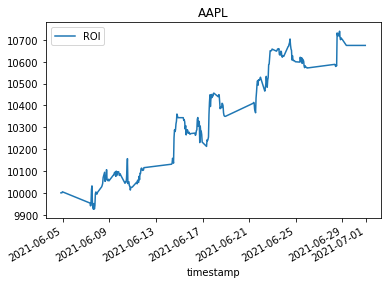

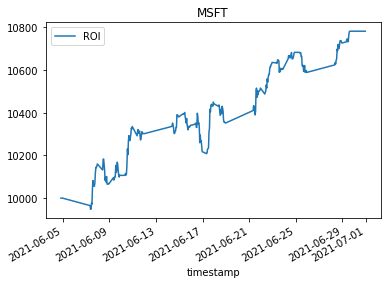

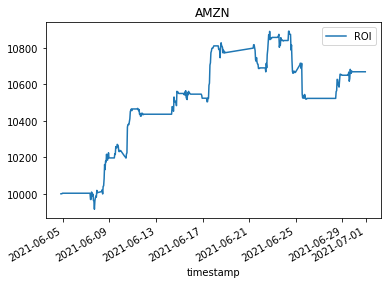

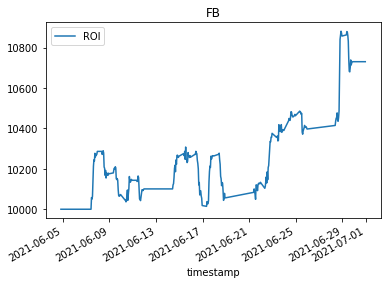

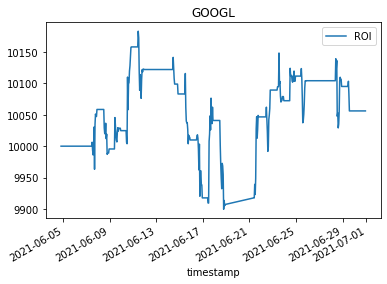

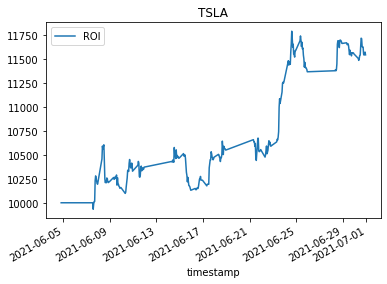

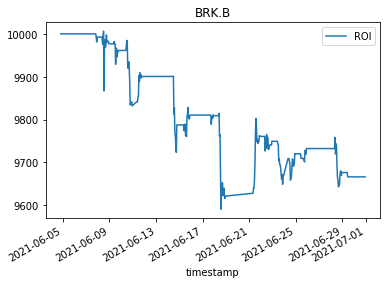

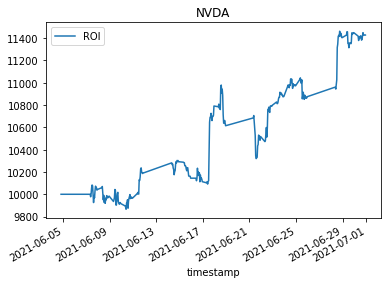

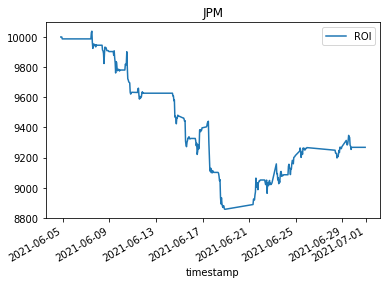

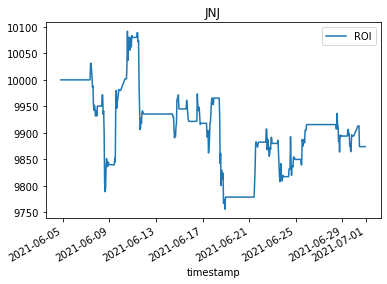

In [15]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    current_returns_df_list[i].plot(y="ROI", title=ticker)

In [16]:
starting_amount = 10000*len(tickers)
ending_amount = 0
for i in range(0,len(tickers)):
    ending_amount += current_returns_df_list[i].iloc[-1,-1]
ending_amount

104687.22735077495

In [19]:
current_returns_df_list[0].head()

,buy_predicted,AAPL,ROI
timestamp,,,
2021-06-04 20:00:00+00:00,0,125.98,10000.000000
2021-06-04 21:00:00+00:00,0,125.99,10000.000000
2021-06-04 22:00:00+00:00,1,125.95,10000.000000
2021-06-04 23:00:00+00:00,1,126.01,10004.763795
2021-06-07 08:00:00+00:00,1,125.36,9953.156014


In [17]:
print("TOTAL BUY SIGNALS------------")
for i in range(0,len(tickers)):
    print(f"{tickers[i]}: {current_returns_df_list[i]['buy_predicted'].sum()}")

TOTAL BUY SIGNALS------------
AAPL: 66
MSFT: 63
AMZN: 64
FB: 80
GOOGL: 53
TSLA: 107
BRK.B: 43
NVDA: 102
JPM: 78
JNJ: 53


In [21]:
summary_df = current_returns_df_list[0].copy()
summary_df = pd.DataFrame(summary_df["ROI"])
summary_df = summary_df.rename(columns={"ROI": f"IMB_{tickers[0]}"})
for i in range(1,len(tickers)):
    temp_df = current_returns_df_list[i].copy()
    temp_df = pd.DataFrame(temp_df["ROI"])
    temp_df = temp_df.rename(columns={"ROI": f"IMB_{tickers[i]}"})
    summary_df = pd.concat([summary_df, temp_df], axis=1)
summary_df.to_csv("imb_roi.csv")